# Communities and Crime Cross-Validation
Data is taken from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime).
> U. S. Department of Commerce, Bureau of the Census, Census Of Population And Housing 1990 United States: Summary Tape File 1a & 3a (Computer Files),
>
> U.S. Department Of Commerce, Bureau Of The Census Producer, Washington, DC and Inter-university Consortium for Political and Social Research Ann Arbor, Michigan. (1992)
>
> U.S. Department of Justice, Bureau of Justice Statistics, Law Enforcement Management And Administrative Statistics (Computer File) U.S. Department Of Commerce, Bureau Of The Census Producer, Washington, DC and Inter-university Consortium for Political and Social Research Ann Arbor, Michigan. (1992)
>
> U.S. Department of Justice, Federal Bureau of Investigation, Crime in the United States (Computer File) (1995)
>
> Redmond, M. A. and A. Baveja: A Data-Driven Software Tool for Enabling Cooperative Information Sharing Among Police Departments. European Journal of Operational Research 141 (2002) 660-678.

*This notebook compares the performance of warped linear regression to ordinary least squares on a cross-validation of the data.*

## Import Dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
np.random.seed(1)

## Load Data

In [2]:
def drop_missing(df):
    drop_columns = []
    for column in df.columns:
        if '?' in list(df[column].values):
            drop_columns.append(column)
    return df.drop(columns=drop_columns)

In [3]:
def load_dataset(filename):
    df = pd.read_csv(filename, header=None)
    df = df.drop(range(5), axis=1)
    df = drop_missing(df)
    X = np.array(df.iloc[:,:-1].values, dtype=float)
    y = np.array(df.iloc[:,-1].values, dtype=float)
    return X, y

In [4]:
X, y = load_dataset("communities.data")
X = StandardScaler().fit_transform(X)

## Set up Cross-Validation Splits

In [5]:
cv_splits = list(KFold(10, shuffle=True).split(X))

## Set Warping Parameters
The warping parameters were fit to maximize the log-likelihood of the training data for each cross-validation using a second order optimizer.

In [6]:
warping_parameters = np.array([
    [2.45539788e+02, 8.21200550e+00, 1.29687713e-01], 
    [2.20807880e+02, 8.18124658e+00, 1.29775771e-01], 
    [2.47853763e+02, 8.33731224e+00, 1.26915050e-01], 
    [2.37965788e+02, 8.22328782e+00, 1.28942838e-01], 
    [2.26799485e+02, 8.24759809e+00, 1.27894342e-01], 
    [2.50334254e+02, 8.11527398e+00, 1.32680489e-01], 
    [2.30428371e+02, 8.34087828e+00, 1.25444850e-01], 
    [-2.48123866e+02,  8.17254228e+00,  1.31001290e-01], 
    [2.29218765e+02, 8.16332304e+00, 1.30279786e-01], 
    [2.21048428e+02, 8.34043339e+00, 1.25391233e-01]])

## Decorator for Vector Functions

In [7]:
def vectorizable(f):
    def f_(x):
        if hasattr(x, '__iter__'):
            return np.array([f(xi) for xi in x])
        return f(x)
    return f_

## Build Warping Function

In [8]:
def make_warper(parameters, y):
    y_mean = np.mean(y)
    y_std = np.std(y)
    def f(t):
        t = (t - y_mean) / (y_std * np.sqrt(len(y)))
        result = t
        for i in range(0, len(parameters), 3):
            a, b, c = parameters[i:(i+3)]
            result += a**2*math.tanh(b**2*(t + c))
        return result
    mean = np.mean([f(yi) for yi in y])
    @vectorizable
    def f_(t):
        return f(t) - mean
    @vectorizable
    def fp(t):
        t = (t - y_mean) / (y_std * np.sqrt(len(y)))
        result = 1.0
        for i in range(0, len(parameters), 3):
            a, b, c = parameters[i:(i+3)]
            u = math.tanh(b**2*(t + c))
            result += a**2*b**2*(1 - u**2)
        result /= y_std * np.sqrt(len(y))
        return result
    return f_, fp

## Compute Log-Likelihood Proxy of Training Data

In [9]:
def compute_log_likelihood_proxy(X, y, phi):
    f, fp = make_warper(phi, y)
    z = f(y)
    model = LinearRegression(fit_intercept=False)
    model.fit(X, z)
    z_pred = model.predict(X)
    rss = sum((z-z_pred)**2)
    return -len(y)/2*np.log(rss) + sum(np.log(fp(y)))

## Verify Maximums
Tweak the warping parameters to verify they're a local maximum of the log-likelihood.

In [10]:
def verify_log_likelihood_opt(X, y, phi):
    delta_x = 1.0e-3
    for i, phi_i in enumerate(phi):
        def f(x):
            phi_copy = np.array(phi)
            phi_copy[i] = x
            return compute_log_likelihood_proxy(X, y, phi_copy)
        f0 = f(phi_i)
        for x in [phi_i - delta_x, phi_i + delta_x]:
            delta_f = f(x) - f0
            relative_delta_f = delta_f / delta_x
            if relative_delta_f > 0 and np.abs(relative_delta_f) > 1.0e-3:
                print(i, x, "\t", delta_f, relative_delta_f)
                assert False, "Can't verify optimum"

In [11]:
for index, (train_indexes, _) in enumerate(cv_splits):
    X_train = X[train_indexes, :]
    y_train = y[train_indexes]
    verify_log_likelihood_opt(X_train, y_train, warping_parameters[index])

## Make Predictions

In [12]:
def compute_prediction_dist(model, xi):
    noise_stddev, beta, A_inv = model
    xi = np.array(list(xi) + [1])
    std_err = noise_stddev * np.sqrt(1 + np.dot(xi, np.dot(A_inv, xi)))
    pred = np.dot(xi, beta)
    return pred, std_err

In [13]:
def compute_prediction_pdf(model, xi):
    pred, std_err = compute_prediction_dist(model, xi)
    @vectorizable
    def pdf(y):
        return norm.pdf(y, loc=pred, scale=std_err)
    return pdf

In [14]:
def compute_warped_prediction_pdf(model, f, fp, xi):
    pred, std_err = compute_prediction_dist(model, xi)
    @vectorizable
    def pdf(y):
        return norm.pdf(f(y), loc=pred, scale=std_err)*fp(y)
    return pdf

In [15]:
def fit_linear_regression_model(X, y):
    X = np.hstack((X, np.ones((X.shape[0], 1))))
    A = np.dot(X.T, X)
    A_inv = np.linalg.inv(A)
    beta = np.dot(A_inv, np.dot(X.T, y))
    y_pred = np.dot(X, beta)
    rss = sum((y-y_pred)**2)
    noise_stddev = np.sqrt(rss / (X.shape[0] - X.shape[1]))
    return noise_stddev, beta, A_inv

In [16]:
def compute_linear_model_log_likelihood(X_train, y_train, X_test, y_test):
    model = fit_linear_regression_model(X_train, y_train)
    result = 0.0
    for xi, yi in zip(X_test, y_test):
        pred, std_err = compute_prediction_dist(model, xi)
        result += norm.logpdf(yi, loc=pred, scale=std_err)
    return result

In [17]:
def compute_warped_linear_model_log_likelihood(phi, X_train, y_train,
                                               X_test, y_test):
    f, fp = make_warper(phi, y_train)
    z_train = f(y_train)
    z_test = f(y_test)
    result = compute_linear_model_log_likelihood(X_train, z_train,
                                                 X_test, z_test)
    result += np.sum(np.log(fp(y_test)))
    return result

## Compute Cross-Validation Scores

In [18]:
linear_cv_log_likelihoods = []
warped_cv_log_likelihoods = []
for index, (train_indexes, test_indexes) in enumerate(cv_splits):
    X_train = X[train_indexes, :]
    y_train = y[train_indexes]
    X_test = X[test_indexes, :]
    y_test = y[test_indexes]
    log_likelihood1 = \
        compute_linear_model_log_likelihood(X_train, y_train,
                                            X_test, y_test)
    log_likelihood2 = \
        compute_warped_linear_model_log_likelihood(
            warping_parameters[index], 
            X_train, y_train,
            X_test, y_test)
    linear_cv_log_likelihoods.append(log_likelihood1)
    warped_cv_log_likelihoods.append(log_likelihood2)

In [19]:
for index, (log_likelihood1, log_likelihood2) in \
    enumerate(zip(linear_cv_log_likelihoods, warped_cv_log_likelihoods)):
        n = len(cv_splits[index][1])
        print("%f\t%f" % (log_likelihood1 / n, log_likelihood2 / n))

0.608949	0.959150
0.450565	1.100966
0.624678	1.028367
0.443151	0.817843
0.706899	1.126734
0.589558	1.017814
0.734414	1.043960
0.602487	0.992717
0.467184	0.992180
0.464309	0.965338


In [20]:
linear_cv_log_likelihood_avg = np.sum(linear_cv_log_likelihoods) / len(y)
warped_cv_log_likelihood_avg = np.sum(warped_cv_log_likelihoods) / len(y)
print("%f\t%f" % (linear_cv_log_likelihood_avg, warped_cv_log_likelihood_avg))

0.569145	1.004451


## Plot Error Distribution

In [21]:
fold = 0
y_range = np.arange(np.min(y), np.max(y), 0.0001)
train_indexes, test_indexes = cv_splits[fold]
X_train = X[train_indexes, :]
y_train = y[train_indexes]
phi = warping_parameters[fold]
f, fp = make_warper(phi, y_train)
z_train = f(y_train)
linear_model = fit_linear_regression_model(X_train, y_train)
warped_model = fit_linear_regression_model(X_train, z_train)

In [22]:
def plot_error_distributions(index, plot):
    xi = X_test[index,:]
    yi = y_test[index]
    p1 = compute_prediction_pdf(linear_model, xi)
    p2 = compute_warped_prediction_pdf(warped_model, f, fp, xi)
    plot.plot(y_range, p1(y_range), label = 'OLS')
    plot.plot(y_range, p2(y_range), label = 'WLR')
    plot.axvline(yi, c='tab:green', label='y_test')    
    plot.legend()

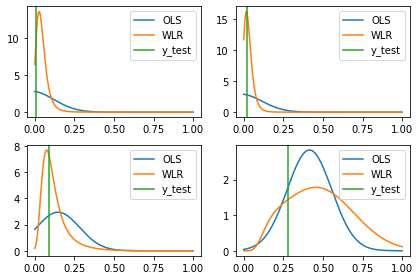

In [23]:
nrows = 2
ncols = 2
indexes = np.random.choice(range(len(cv_splits[0][1])), nrows*ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
index = 0
for i in range(nrows):
    for j in range(ncols):
        plot_error_distributions(indexes[index], axes[i, j])
        index += 1
fig.tight_layout()